<a href="https://colab.research.google.com/github/bi-horn/ML_Heart_Disease/blob/main/ML_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart disease prediction with ML algorithms

In [1]:
#Mount Google Drive
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
#from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()

In [3]:
# Importing data
data_path = '/content/drive/My Drive/heart_disease/data/preprocessed_data_chd.csv'

df = pd.read_csv(data_path)

In [4]:
df.head()

,age,education,sex,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,ten_year_chd,pulse_pressure
0,1.812913,2,0,0.602060,0,0,0,0,2.346353,1.421275,1.959041,1.908485,1,1.806180
1,1.568202,4,1,0.301030,0,0,1,0,2.328380,1.488127,1.863323,1.880814,0,1.851258
2,1.672098,1,0,1.041393,0,0,0,0,2.399674,1.329398,1.949390,1.977724,0,1.662758
3,1.707570,1,1,1.322219,0,0,1,0,2.369216,1.466274,1.838849,1.977724,1,1.851258
4,1.812913,1,0,1.491362,0,0,0,0,2.383815,1.438067,1.851258,1.892095,0,1.720159


In [5]:
#exclude all categorical variables or contonuous variables

cat_var = ['education', 'sex', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'ten_year_chd']
cont_var = ['age', 'cigs_per_day', 'total_cholesterol', 'pulse_pressure', 'bmi', 'heart_rate', 'glucose']
dependent_var = ['ten_year_chd'] #label 0/1

# df with continuous variables only
df_cont = df.drop(columns=cat_var)

#df with categorical variables only
df_cat = df.drop(columns=cont_var)

## Train Test Split

In [6]:
# Split the data into training and testing dataset
dependent_var = ['ten_year_chd']
X = df.drop('ten_year_chd',axis=1)
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #70% training and 30% test

##### Handling the previously detected outliers

To remember:
For the feature age, number of outliers is 0

For the feature cigs_per_day, number of outliers is 17

For the feature total_cholesterol, number of outliers is 19

For the feature bmi, number of outliers is 46

For the feature heart_rate, number of outliers is 19

For the feature glucose, number of outliers is 42

For the feature pulse_pressure, number of outliers is 46

-> bmi, glucose and pulse pressure have the most outliers

Replacement of the outlier with median value

In [7]:
X_train[cont_var].skew(axis = 0)

age                  0.001493
cigs_per_day         0.415730
total_cholesterol   -0.035148
pulse_pressure       0.317981
bmi                  0.322960
heart_rate           0.166288
glucose              2.421207
dtype: float64

In [8]:
# imputing the outliers beyond 3 standard deviations from the mean with its median value
for i in ['total_cholesterol', 'bmi', 'heart_rate', 'glucose','pulse_pressure']:
  upper_lim = X_train[i].mean() + 3 * X_train[i].std()
  lower_lim = X_train[i].mean() - 3 * X_train[i].std()
  X_train.loc[(X_train[i] > upper_lim),i] = X_train[i].median()
  X_train.loc[(X_train[i] < lower_lim),i] = X_train[i].median()

In [9]:
X_train[cont_var].skew(axis = 0)

age                  0.001493
cigs_per_day         0.415730
total_cholesterol   -0.061667
pulse_pressure       0.294085
bmi                  0.157580
heart_rate           0.072795
glucose              0.383163
dtype: float64

## Oversampling

To mitigate this imbalance, dataset resampling will be performed. The chosen approach is SMOTE (Synthetic Minority Oversampling Technique). This technique randomly selects points from the minority class and identifies their k-nearest neighbors. Synthetic points are then generated between these selected points and their neighbors.

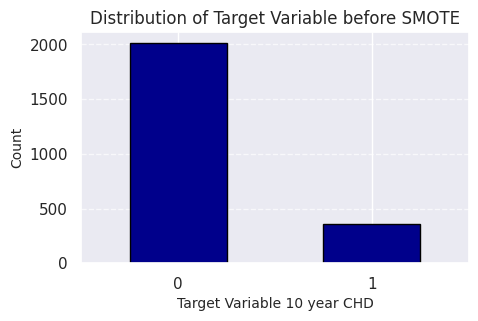

In [10]:
# visualize the target variable before SMOTE
plt.figure(figsize=(5, 3))
y_train.value_counts().plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Distribution of Target Variable before SMOTE', fontsize=12)
plt.xlabel('Target Variable 10 year CHD', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [11]:
# Oversampling using SMOTE
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Samples in the original dataset', len(y_train))
print('Samples in the resampled dataset', len(y_smote))

Samples in the original dataset 2373
Samples in the resampled dataset 4022


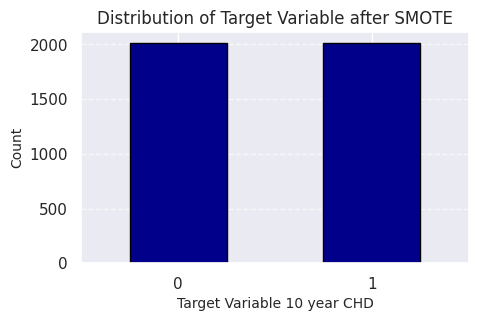

In [12]:
# visualize the target variable before SMOTE
plt.figure(figsize=(5, 3))
y_smote.value_counts().plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Distribution of Target Variable after SMOTE', fontsize=12)
plt.xlabel('Target Variable 10 year CHD', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
#scale the data
# Scaling data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_smote_scaled = scaler.fit_transform(X_smote)
X_test_scaled = scaler.transform(X_test)

# Converting array to dataframe
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_smote_scaled = pd.DataFrame(X_smote_scaled,columns=X_smote.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [52]:
X_train_scaled.head()

,age,education,sex,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,pulse_pressure
0,1.730201,-0.930006,-0.884894,-0.886226,5.628028,-0.081741,1.462494,-0.165145,1.211338,-0.512642,0.436764,-0.243806,0.995876
1,0.463675,-0.930006,-0.884894,-0.886226,-0.177682,-0.081741,1.462494,-0.165145,0.751225,0.769859,1.515195,1.751492,1.025783
2,-0.351498,1.026686,-0.884894,1.151795,-0.177682,-0.081741,-0.683763,-0.165145,0.581872,-0.723928,-0.846823,0.412337,-0.151460
3,-1.153397,-0.930006,-0.884894,1.920852,-0.177682,-0.081741,-0.683763,-0.165145,-0.326319,-1.414613,1.224208,-2.124776,-0.233465
4,0.242084,0.048340,-0.884894,-0.886226,-0.177682,-0.081741,-0.683763,-0.165145,0.016925,0.815595,-0.266663,0.412337,-1.863356


In [53]:
X_smote_scaled.head()

,age,education,sex,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,bmi,heart_rate,glucose,pulse_pressure
0,1.561274,-0.856739,-0.960735,-0.918847,5.352720,-0.091307,1.243487,-0.169258,1.183724,-0.600946,0.471892,-0.283554,0.811663
1,0.241274,-0.856739,-0.960735,-0.918847,-0.186821,-0.091307,1.243487,-0.169258,0.693010,0.736945,1.633784,1.829731,0.841709
2,-0.608316,1.097391,-0.960735,1.096771,-0.186821,-0.091307,-0.804190,-0.169258,0.512394,-0.821359,-0.911035,0.411388,-0.341007
3,-1.444072,-0.856739,-0.960735,1.857375,-0.186821,-0.091307,-0.804190,-0.169258,-0.456198,-1.541874,1.320278,-2.275752,-0.423394
4,0.010328,0.120326,-0.960735,-0.918847,-0.186821,-0.091307,-0.804190,-0.169258,-0.090126,0.784657,-0.285975,0.411388,-2.060864


In [14]:
#evaluating model
def evaluate(C, X_test, y_test): #C-Classifier
    y_pred = C.predict(X_test)

    k_fold = KFold(10, shuffle = True, random_state = 0) #10-fold cross-validation
    cv_scores = cross_val_score(C, X_test, y_test.values.ravel(), cv = k_fold)

    print("Cross-validation score means: ", cv_scores.mean())

    print("Accuracy: ", accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))

In [15]:
#training SVM SVC w/rbf kernel
C = svm.SVC(gamma = 'scale') #create classifier
C.fit(X_smote_scaled, y_smote) #train classifier

evaluate(C, X_test_scaled, y_test)

Cross-validation score means:  0.8514948553678897
Accuracy:  0.7010816125860374
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       868
           1       0.21      0.36      0.26       149

    accuracy                           0.70      1017
   macro avg       0.54      0.56      0.54      1017
weighted avg       0.78      0.70      0.73      1017



In [16]:
#training random forest classifier
C = RandomForestClassifier(n_estimators = 100)
C.fit(X_smote_scaled, y_smote) #train classifier

evaluate(C, X_test_scaled, y_test)

Cross-validation score means:  0.8534265191225006
Accuracy:  0.7895771878072763
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       868
           1       0.26      0.24      0.25       149

    accuracy                           0.79      1017
   macro avg       0.57      0.56      0.56      1017
weighted avg       0.78      0.79      0.79      1017



In [17]:
#training Gaussian Naive Bayes classifier
C = GaussianNB()
C.fit(X_smote_scaled, y_smote) #train classifier

evaluate(C, X_test_scaled, y_test)


Cross-validation score means:  0.8426033779848572
Accuracy:  0.7384464110127827
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       868
           1       0.27      0.46      0.34       149

    accuracy                           0.74      1017
   macro avg       0.58      0.62      0.59      1017
weighted avg       0.80      0.74      0.76      1017



In [18]:
#training supervised MLP
C = MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (100,))
C.fit(X_smote_scaled, y_smote) #train classifier

evaluate(C, X_test_scaled, y_test)

Cross-validation score means:  0.7777227722772276
Accuracy:  0.7246804326450345
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       868
           1       0.17      0.23      0.20       149

    accuracy                           0.72      1017
   macro avg       0.52      0.52      0.52      1017
weighted avg       0.76      0.72      0.74      1017



In [19]:
#training KNN
C = KNeighborsClassifier(n_neighbors = 3)
C.fit(X_smote_scaled, y_smote) #train classifier

evaluate(C, X_test_scaled, y_test)

Cross-validation score means:  0.81410405746457
Accuracy:  0.6263520157325467
              precision    recall  f1-score   support

           0       0.86      0.67      0.75       868
           1       0.17      0.39      0.23       149

    accuracy                           0.63      1017
   macro avg       0.52      0.53      0.49      1017
weighted avg       0.76      0.63      0.68      1017



In [20]:
#Training logistic regression model
C = LogisticRegression(solver = 'lbfgs')
C.fit(X_smote_scaled, y_smote) #train classifier
# Test predictions
evaluate(C, X_test_scaled, y_test)
lr_test_pred = C.predict(X_test_scaled)
#print(lr_test_pred)

Cross-validation score means:  0.8583673073189673
Accuracy:  0.6696165191740413
              precision    recall  f1-score   support

           0       0.92      0.67      0.78       868
           1       0.26      0.66      0.37       149

    accuracy                           0.67      1017
   macro avg       0.59      0.66      0.57      1017
weighted avg       0.82      0.67      0.72      1017



[[583 285]
 [ 51  98]]


[Text(0, 0.5, 'No Risk'), Text(0, 1.5, 'At Risk')]

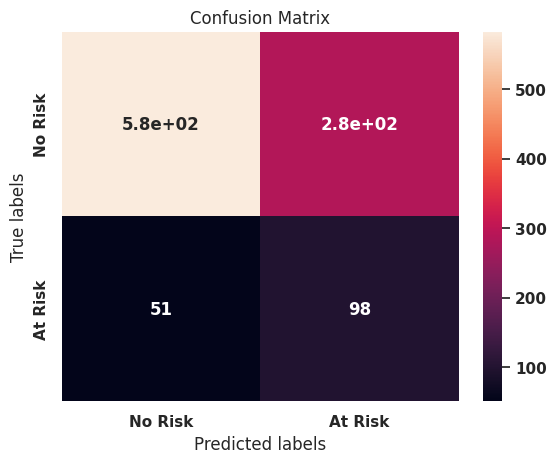

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd

# Get the confusion matrix for test
labels = ['No Risk', 'At Risk']
cm = confusion_matrix(y_test, lr_test_pred)
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
